In [ ]:
import cv2

# Define paths
video_path = '/content/WhatsApp Video 2025-02-17 at 19.08.26.mp4'      # Your existing video
output_path = '/content/clahe_output.mp4'   # Output path

# Open video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Could not open video at " + video_path)

# Get video properties
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

# Define output video writer
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Create CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Process video frame by frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to LAB color space
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L-channel
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Write the frame
    out.write(enhanced)

# Clean up
cap.release()
out.release()


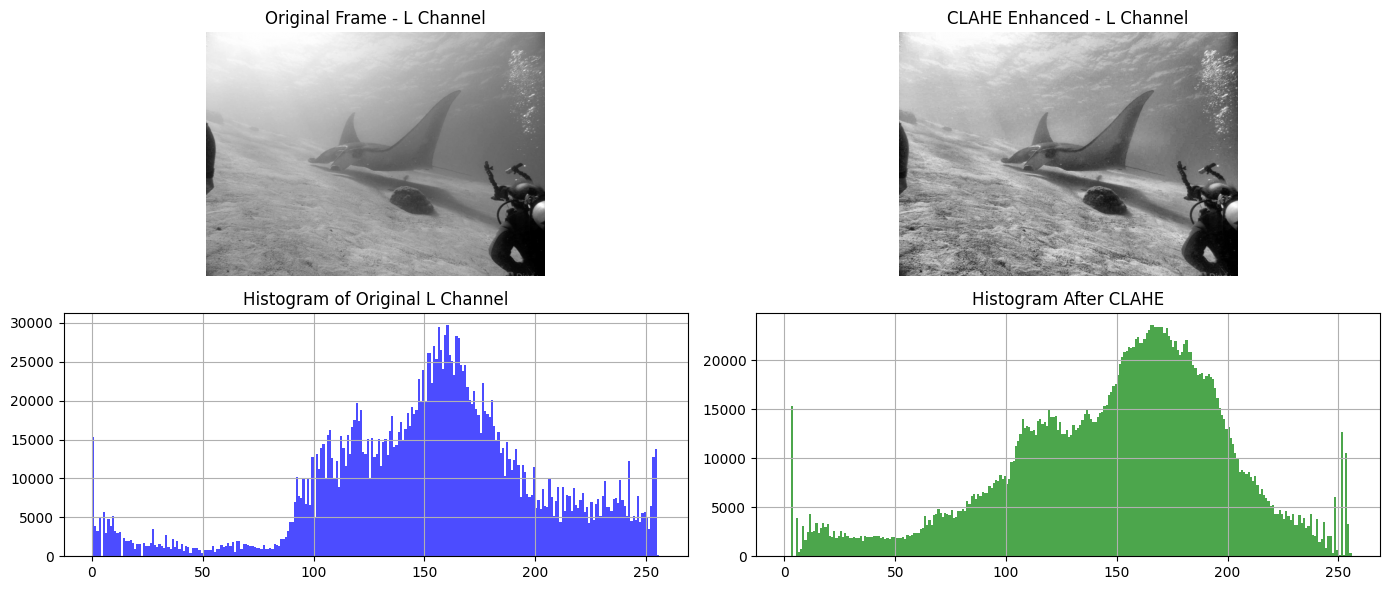

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a single frame (first frame)
cap = cv2.VideoCapture('/content/706.jpg')
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Couldn't read a frame from the video.")

# Convert to LAB and split channels
lab_original = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
l_orig, a, b = cv2.split(lab_original)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_clahe = clahe.apply(l_orig)

# Plot original and CLAHE-enhanced histograms
plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
plt.title('Original Frame - L Channel')
plt.imshow(l_orig, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('CLAHE Enhanced - L Channel')
plt.imshow(l_clahe, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Histogram of Original L Channel')
plt.hist(l_orig.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Histogram After CLAHE')
plt.hist(l_clahe.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
plt.grid(True)

plt.tight_layout()
plt.show()


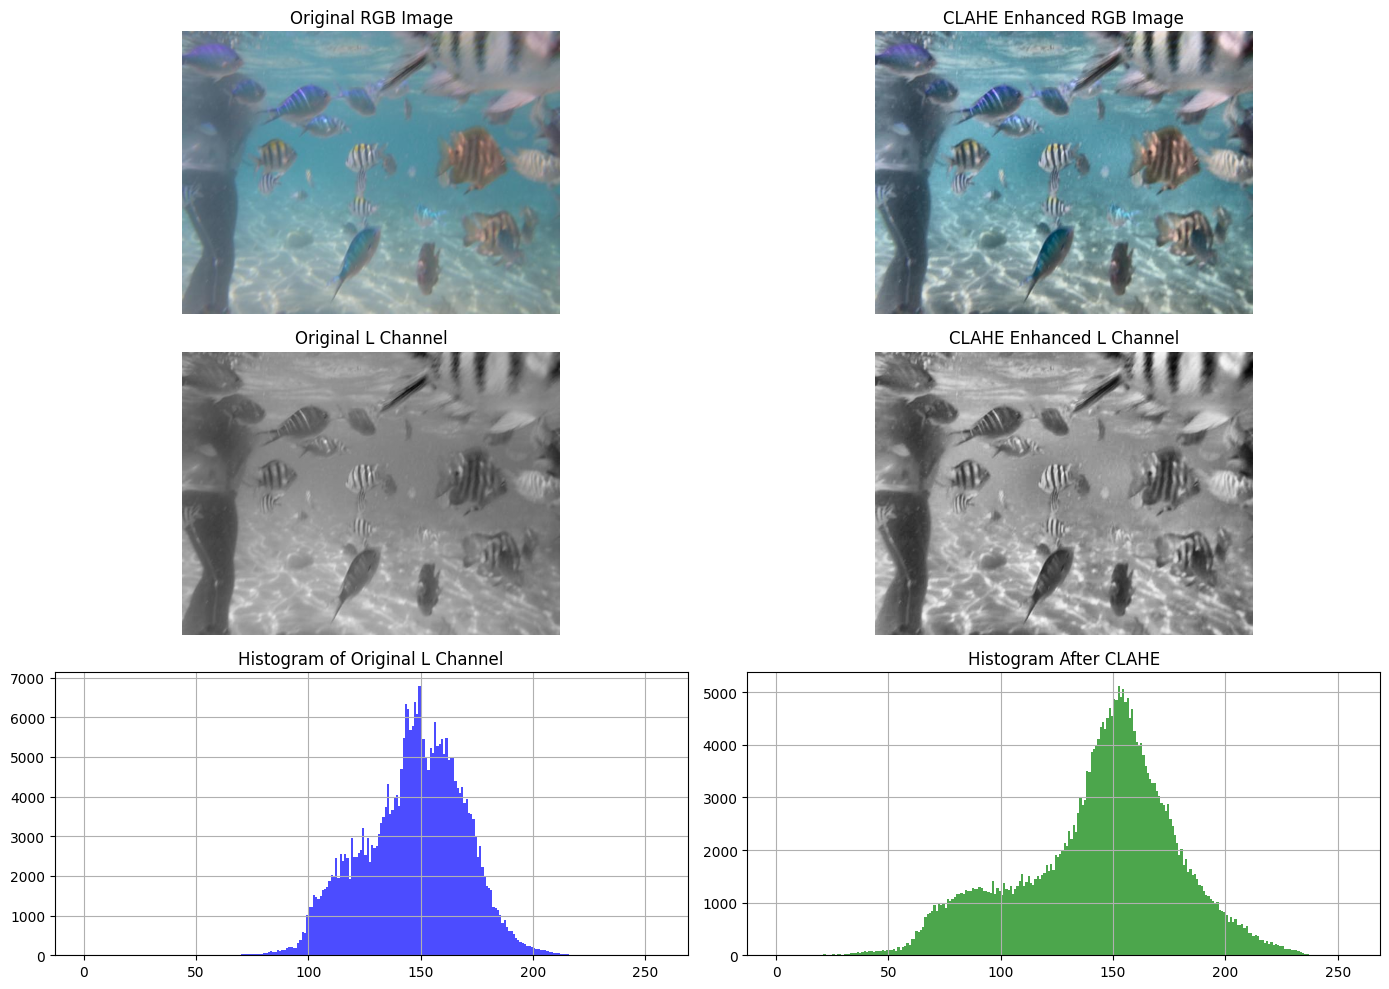

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (not a video — your path points to a PNG)
frame = cv2.imread('/content/182.jpg')

if frame is None:
    raise ValueError("Couldn't load the image. Check the file path.")

# Convert BGR to LAB
lab_original = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
l_orig, a, b = cv2.split(lab_original)

# Apply CLAHE to the L channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_clahe = clahe.apply(l_orig)

# Merge back to get CLAHE-enhanced LAB image and convert to BGR
lab_clahe = cv2.merge((l_clahe, a, b))
clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# Convert to RGB for displaying with matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
clahe_rgb = cv2.cvtColor(clahe_bgr, cv2.COLOR_BGR2RGB)

# Plotting
plt.figure(figsize=(14, 10))

# --- Original and Enhanced Full Images ---
plt.subplot(3, 2, 1)
plt.title('Original RGB Image')
plt.imshow(frame_rgb)
plt.axis('off')

plt.subplot(3, 2, 2)
plt.title('CLAHE Enhanced RGB Image')
plt.imshow(clahe_rgb)
plt.axis('off')

# --- L-channel grayscale views ---
plt.subplot(3, 2, 3)
plt.title('Original L Channel')
plt.imshow(l_orig, cmap='gray')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.title('CLAHE Enhanced L Channel')
plt.imshow(l_clahe, cmap='gray')
plt.axis('off')

# --- Histograms ---
plt.subplot(3, 2, 5)
plt.title('Histogram of Original L Channel')
plt.hist(l_orig.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
plt.grid(True)

plt.subplot(3, 2, 6)
plt.title('Histogram After CLAHE')
plt.hist(l_clahe.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
plt.grid(True)

plt.tight_layout()
plt.show()


Original Image:


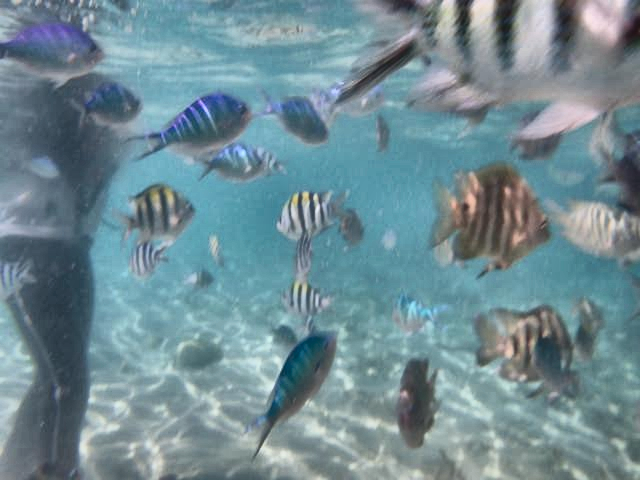

Enhanced Image:


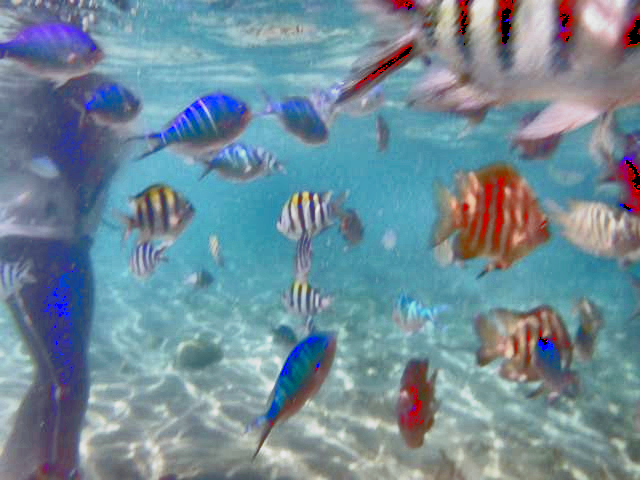

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Use this instead of cv2.imshow

class AdaptiveColorEnhancer:
    def __init__(self, clip_value=0.02, alpha=0.00005, preserve_shades=True):
        self.clip_value = clip_value
        self.alpha = alpha
        self.preserve_shades = preserve_shades
        self.low_values = np.array([0.0, 0.0, 0.0])
        self.high_values = np.array([255.0, 255.0, 255.0])
        self.initialized = False

    def enhance(self, img):
        img = img.astype(np.float32)
        enhanced = np.zeros_like(img)

        for i in range(3):  # B, G, R channels
            channel = img[:, :, i]
            p_low = np.percentile(channel, 100 * self.clip_value)
            p_high = np.percentile(channel, 100 * (1 - self.clip_value))

            if not self.initialized:
                self.low_values[i] = p_low
                self.high_values[i] = p_high
            else:
                self.low_values[i] = (1 - self.alpha) * self.low_values[i] + self.alpha * p_low
                self.high_values[i] = (1 - self.alpha) * self.high_values[i] + self.alpha * p_high

            low, high = self.low_values[i], self.high_values[i]
            stretched = (channel - low) / (high - low + 1e-6)
            stretched = np.clip(stretched, 0, 1) * 255
            enhanced[:, :, i] = stretched

        self.initialized = True

        if self.preserve_shades:
            gray_original = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32) + 1e-6
            gray_enhanced = cv2.cvtColor(enhanced.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32) + 1e-6
            ratio = gray_original / gray_enhanced
            ratio = np.expand_dims(ratio, axis=2)
            enhanced = enhanced * ratio
            enhanced = np.clip(enhanced, 0, 255)

        return enhanced.astype(np.uint8)


# Example usage in Colab
if __name__ == "__main__":
    # Load an image
    image = cv2.cvtColor(clahe_rgb, cv2.COLOR_RGB2BGR)


    # Initialize the enhancer
    enhancer = AdaptiveColorEnhancer(clip_value=0.01, alpha=0.00005, preserve_shades=True)

    # Apply enhancement
    enhanced_img = enhancer.enhance(image)

    # Display results in Colab
    print("Original Image:")
    cv2_imshow(image)
    print("Enhanced Image:")
    cv2_imshow(enhanced_img)

    # Save the result
    cv2.imwrite("/content/enhanced_underwater.jpg", enhanced_img)


Original Image:


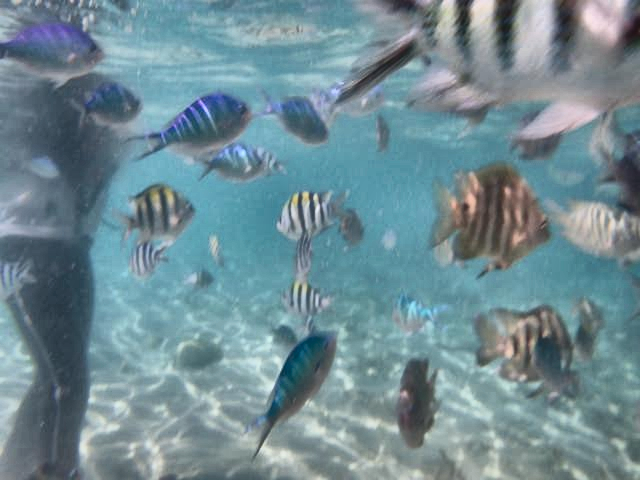

Detected bias: greenish
Enhanced Image:


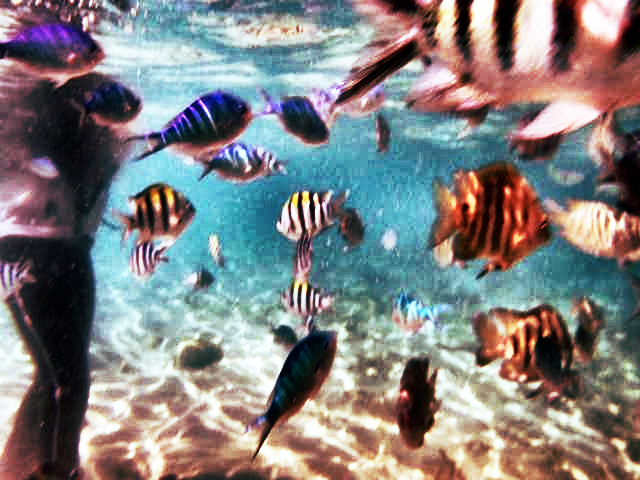

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


class AdaptiveColorEnhancer:
    def __init__(self, alpha=1.0, beta=1.0, block_size=64):
        """
        Implements adaptive color balance correction as described in the paper.
        Args:
            alpha, beta: Constants for compensation equations.
            block_size: Region size for background estimation.
        """
        self.alpha = alpha
        self.beta = beta
        self.block_size = block_size

    def get_background_region(self, img):
        """
        Find the brightest, lowest-variance block (approximating illumination color).
        """
        h, w, _ = img.shape
        best_region = None
        min_var = float('inf')
        max_brightness = 0

        for y in range(0, h - self.block_size, self.block_size):
            for x in range(0, w - self.block_size, self.block_size):
                block = img[y:y+self.block_size, x:x+self.block_size]
                mean_brightness = np.mean(block)
                var = np.var(block)

                if mean_brightness > max_brightness and var < min_var:
                    best_region = block
                    max_brightness = mean_brightness
                    min_var = var

        return best_region if best_region is not None else img

    def classify_bias(self, region):
        """
        Classify image type based on dominant channel in background region.
        Returns: 'bluish', 'greenish', 'yellowish', or 'colorless'
        """
        mean_vals = np.mean(region.reshape(-1, 3), axis=0)  # B, G, R
        b, g, r = mean_vals

        if b > g and b > r:
            return "bluish"
        elif g > r and g > b:
            return "greenish"
        elif r > g and r > b:
            return "yellowish"
        else:
            return "colorless"

    def gain_adjustment(self, img):
        """
        Apply gain normalization to stretch dynamic range per channel.
        """
        out = np.zeros_like(img, dtype=np.float32)
        for c in range(3):
            I_min = np.min(img[:, :, c])
            I_max = np.max(img[:, :, c])
            D = I_max - I_min + 1e-6
            K = 255.0 / D
            out[:, :, c] = K * (img[:, :, c] - I_min)
        return np.clip(out, 0, 255).astype(np.uint8)

    def enhance(self, img):
        """
        Perform full adaptive color correction.
        """
        img = img.astype(np.float32)
        background = self.get_background_region(img)
        bias_type = self.classify_bias(background)
        print(f"Detected bias: {bias_type}")

        # Mean values from background
        mean_vals = np.mean(background.reshape(-1, 3), axis=0)
        b_mean, g_mean, r_mean = mean_vals

        enhanced = img.copy()

        # Case 1: Greenish → Histogram normalization for each channel
        if bias_type == "greenish":
            for c in range(3):
                ch = enhanced[:, :, c]
                ch = cv2.equalizeHist(ch.astype(np.uint8))
                enhanced[:, :, c] = ch.astype(np.float32)

        # Case 2: Bluish → Compensate red using green channel (gray-world assumption)
        elif bias_type == "bluish":
           r = enhanced[:, :, 2] / 255.0
           g = enhanced[:, :, 1] / 255.0
           delta = (g_mean - r_mean) / 255.0
           enhanced[:, :, 2] = (r + self.alpha * delta * (1 - r) * g) * 255.0

        # Case 3: Yellowish → Compensate green and blue using red channel
        elif bias_type == "yellowish":
            g = enhanced[:, :, 1] / 255.0
            b = enhanced[:, :, 0] / 255.0
            r = enhanced[:, :, 2] / 255.0
            delta_g = (r_mean - g_mean) / 255.0
            delta_b = (r_mean - b_mean) / 255.0
            enhanced[:, :, 1] = (g + self.alpha * delta_g * (1 - g) * r) * 255.0
            enhanced[:, :, 0] = (b + self.beta * delta_b * (1 - b) * r) * 255.0
        # Case 4: Colorless → no correction, skip to gain adjustment
        else:
            pass

        # Apply gain adjustment to all channels
        enhanced = self.gain_adjustment(enhanced)

        return enhanced.astype(np.uint8)


# Example usage in Colab
if __name__ == "__main__":
    # Load input image (BGR)
    image = cv2.cvtColor(clahe_rgb, cv2.COLOR_RGB2BGR)
    if image is None:
        raise FileNotFoundError("Input image not found. Please upload an underwater image.")

    print("Original Image:")
    cv2_imshow(image)



    # Initialize enhancer
    enhancer = AdaptiveColorEnhancer(alpha=1, beta=0.01, block_size=64)

    # Apply adaptive color enhancement
    enhanced_img = enhancer.enhance(image)
    print("Enhanced Image:")
    cv2_imshow(enhanced_img)

    # Save result
    cv2.imwrite("/content/enhanced_underwater.jpg", enhanced_img)


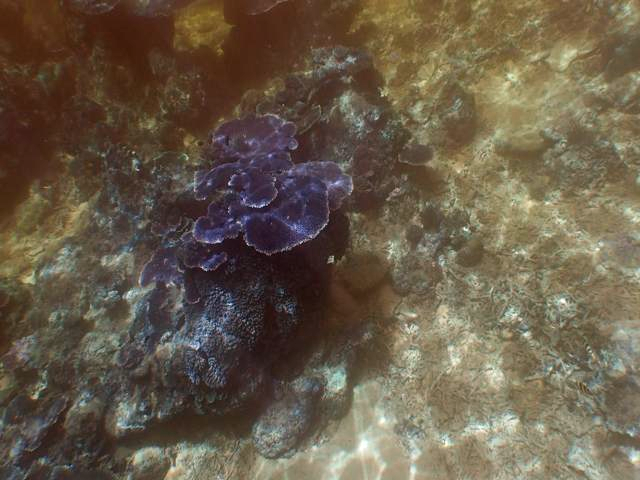

In [ ]:
image2=enhanced_img
swapped = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
cv2_imshow(swapped)


Original Image:


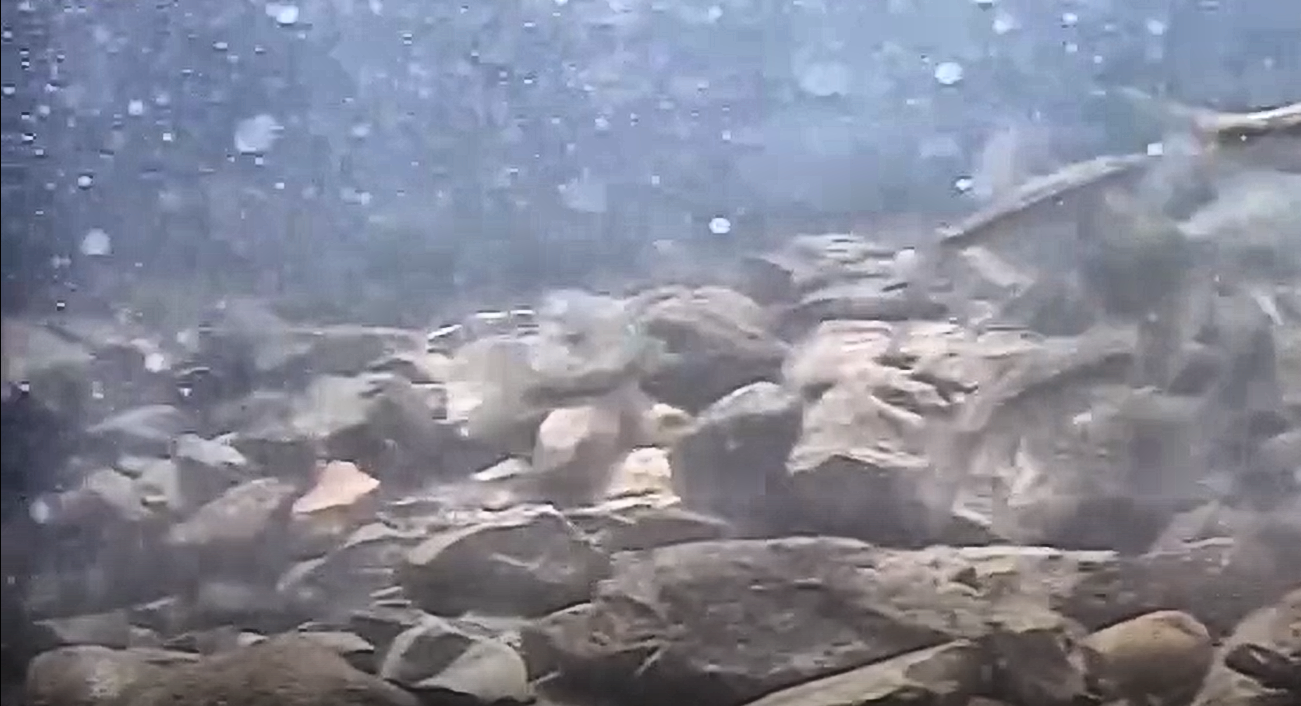

Enhanced Image:


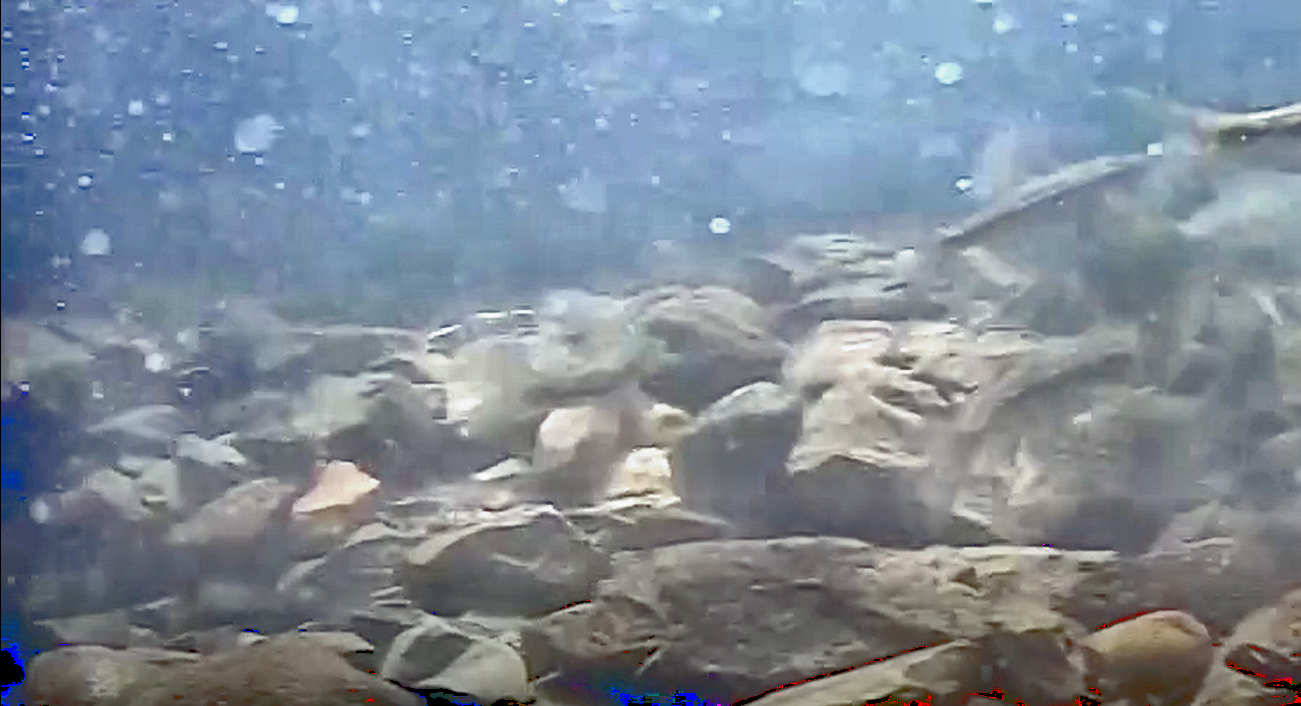

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Use this instead of cv2.imshow

class AdaptiveColorEnhancer:
    def __init__(self, clip_value=0.02, alpha=0.00005, preserve_shades=True):
        self.clip_value = clip_value
        self.alpha = alpha
        self.preserve_shades = preserve_shades
        self.low_values = np.array([0.0, 0.0, 0.0])
        self.high_values = np.array([255.0, 255.0, 255.0])
        self.initialized = False

    def enhance(self, img):
        img = img.astype(np.float32)
        enhanced = np.zeros_like(img)

        for i in range(3):  # B, G, R channels
            channel = img[:, :, i]
            p_low = np.percentile(channel, 100 * self.clip_value)
            p_high = np.percentile(channel, 100 * (1 - self.clip_value))

            if not self.initialized:
                self.low_values[i] = p_low
                self.high_values[i] = p_high
            else:
                self.low_values[i] = (1 - self.alpha) * self.low_values[i] + self.alpha * p_low
                self.high_values[i] = (1 - self.alpha) * self.high_values[i] + self.alpha * p_high

            low, high = self.low_values[i], self.high_values[i]
            stretched = (channel - low) / (high - low + 1e-6)
            stretched = np.clip(stretched, 0, 1) * 255
            enhanced[:, :, i] = stretched

        self.initialized = True

        if self.preserve_shades:
            gray_original = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32) + 1e-6
            gray_enhanced = cv2.cvtColor(enhanced.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32) + 1e-6
            ratio = gray_original / gray_enhanced
            ratio = np.expand_dims(ratio, axis=2)
            enhanced = enhanced * ratio
            enhanced = np.clip(enhanced, 0, 255)

        return enhanced.astype(np.uint8)


# Example usage in Colab
if __name__ == "__main__":
    # Load an image


    # Initialize the enhancer
    enhancer = AdaptiveColorEnhancer(clip_value=0.005, alpha=0.00005, preserve_shades=True)

    # Apply enhancement
    enhanced_img = enhancer.enhance(image)

    # Display results in Colab
    print("Original Image:")
    cv2_imshow(image)
    print("Enhanced Image:")
    cv2_imshow(enhanced_img)




In [ ]:
from google.colab import files
files.download('/content/clahe_output.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>